In [222]:
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
import numpy as np
import seaborn as sns
from matplotlib.animation import FuncAnimation
from functools import lru_cache
import requests
import time

In [102]:
# Define shapefile object
SHAPEFILE = "tl_2021_us_state.shp"

# Read shapefile to new geopandas object
geo_df =  gpd.read_file(SHAPEFILE)
    
# Drop states that are not part of continental US
geo_df = geo_df.drop(geo_df.loc[geo_df['STUSPS'] == "AK"].index)
geo_df = geo_df.drop(geo_df.loc[geo_df['STUSPS'] == "HI"].index)
geo_df = geo_df.drop(geo_df.loc[geo_df['STUSPS'] == "PR"].index)

In [104]:
geo_df1 = geo_df[['STUSPS','geometry']]

In [105]:
# Read claim volume file
states_df = pd.read_csv("states.csv") 
    
# Convert date to datetime
states_df.date = pd.to_datetime(states_df.date)

In [113]:
states_df['month'] = states_df['date'].dt.month
#m_states_df['month'] = m_states_df['month'].astype(int)
m_states_df = states_df.groupby(['state', pd.Grouper(key='date', freq='1M'), 'month']).sum()
m_states_df = m_states_df.droplevel('date')

claim_volume
state month              
AK    1          625642.0
      2          205763.0
      3          593387.0
      4          441311.0
      5          793091.0
...                   ...
WY    6          273376.0
      7          298664.0
      8          392149.0
      9          418304.0
      10         480260.0

[510 rows x 1 columns]

In [114]:
# Reshape Claim Volume to fit 2DArray reqs for normalize function
d = m_states_df['claim_volume'].values.reshape(-1,1)

# Normalize Claim Volume and append new column to DataFrame
b = preprocessing.normalize(d, axis=0)
scaled_df = m_states_df
scaled_df['scaled'] = b

In [116]:
geo_df2 = geo_df1.rename(columns={"STUSPS": "state"})

In [117]:
geo_df2= geo_df2.set_index('state')

In [119]:
# Merge Shapefile and Claim Volume Data Frames
merged_df = pd.merge(left=scaled_df, right=geo_df2, how='right', left_index=True, right_index=True)

In [120]:
merged = GeoDataFrame(merged_df)

In [121]:
merged = merged.drop('claim_volume', axis=1)

In [137]:
merged_trim = merged.droplevel(level=0)

<IPython.core.display.Javascript object>


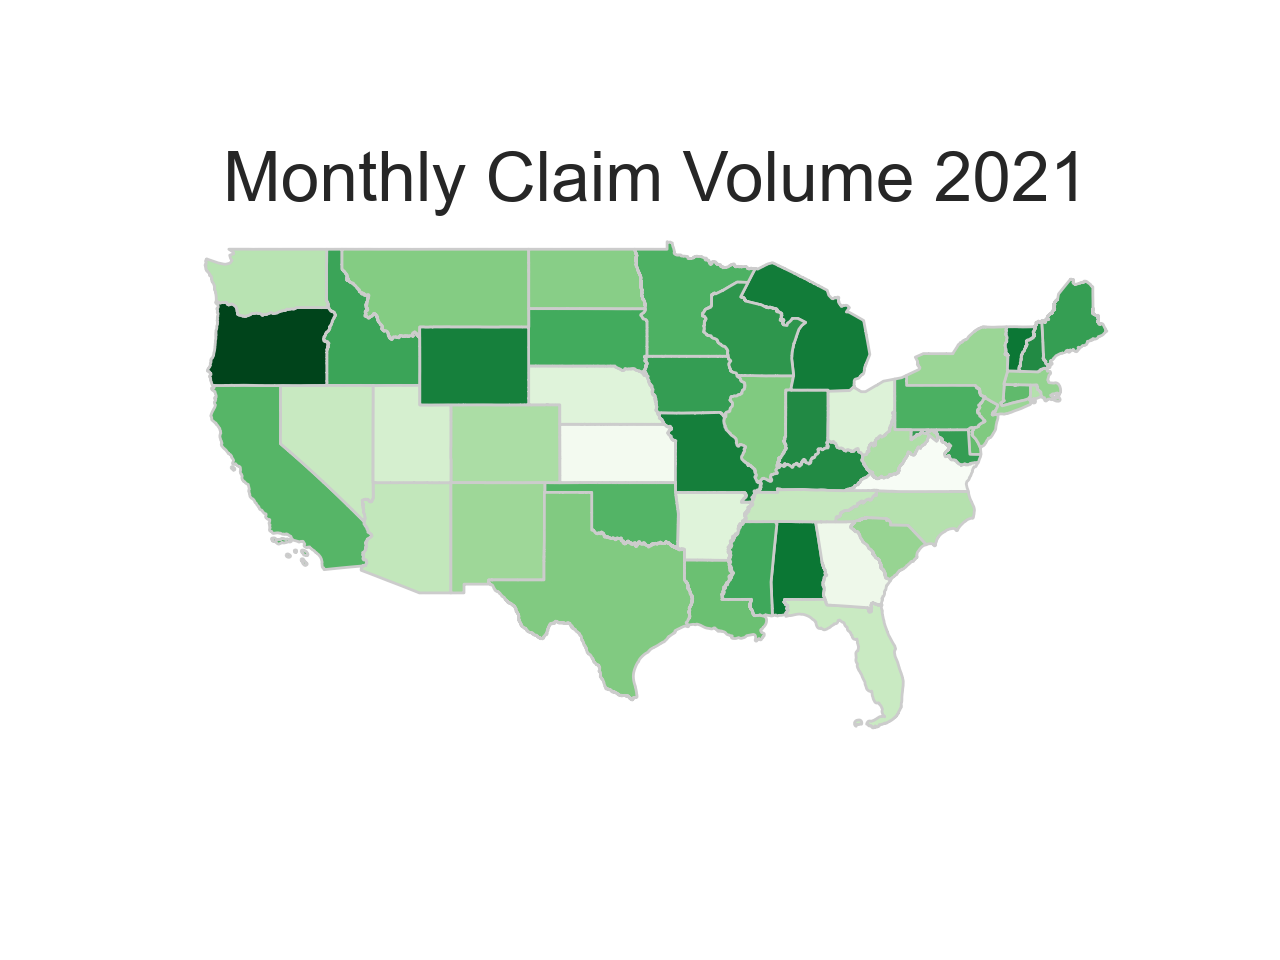

<AxesSubplot:title={'center':'Monthly Claim Volume 2021'}>

In [214]:
merged_filter = merged.query("month == 1")
%matplotlib notebook
fig, ax = plt.subplots()
col = 'scaled'
colors = 'Greens'
sns.set_style(style = 'white')

cmap = sns.diverging_palette(250, 10, as_cmap=True)
cmap=plt.get_cmap(colors)

# Remove the axis and plot
ax.axis('off')

# Add a title
ax.set_title('Monthly Claim Volume 2021', fontdict={'fontsize': '25', 'fontweight': '3'})
merged_filter.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)

In [173]:
# Set a list for months in a np array
months = np.sort(np.unique(states_df.date.dt.month.values))
display(months)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [230]:
list = []

for month in months:
    list.append(merged.query("month == @month"))

In [232]:
print(len(list))

10


<IPython.core.display.Javascript object>


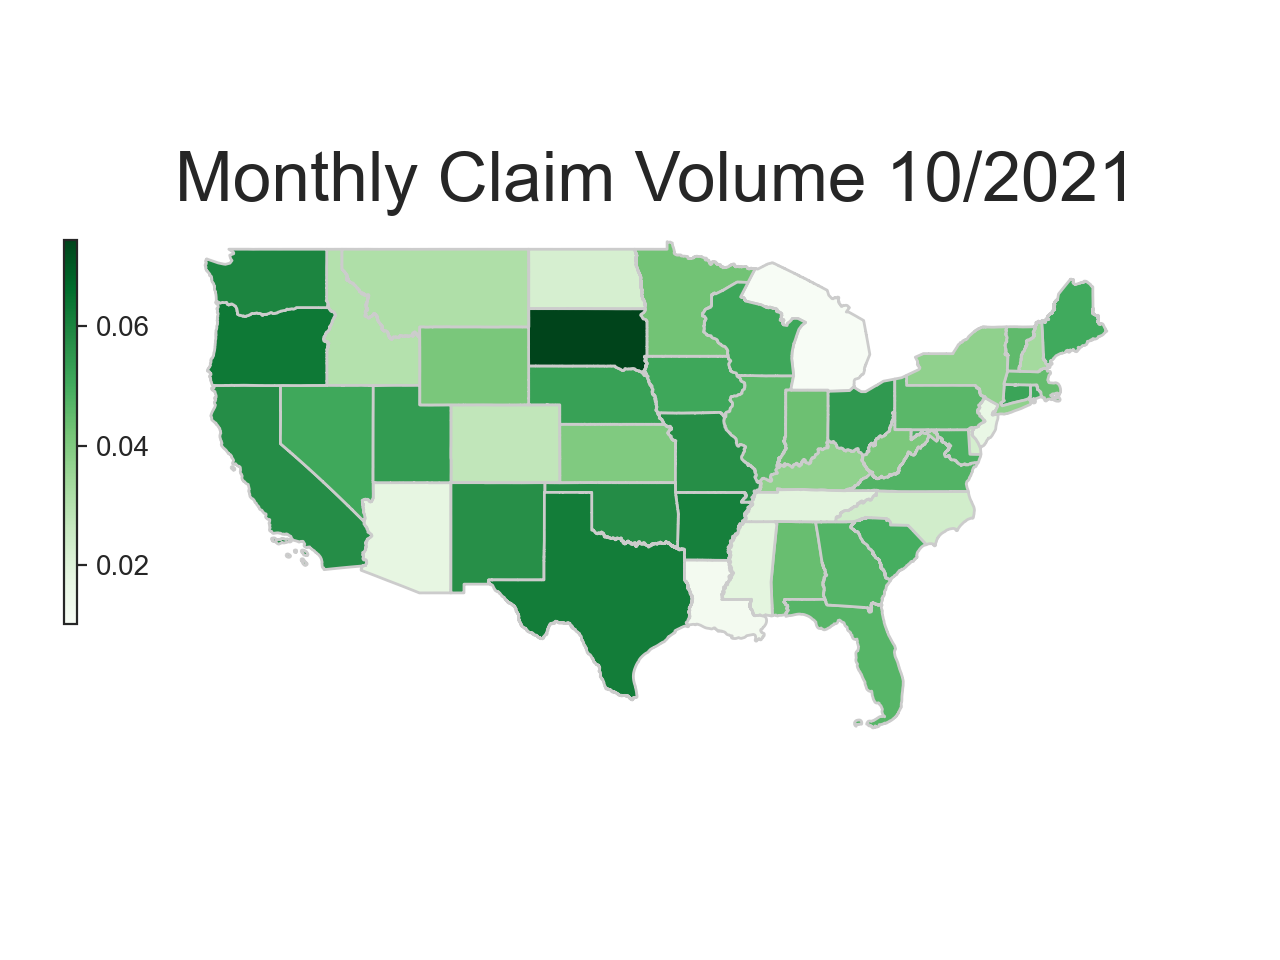

In [306]:
# Create figure and axes for Matplotlib
%matplotlib notebook
fig, ax = plt.subplots()
ax.axis('off')
col = 'scaled'
colors = 'Greens'
sns.set_style(style = 'white')
cmap = sns.diverging_palette(250, 10, as_cmap=True)
cmap=plt.get_cmap(colors)
vmin = merged_filter[col].min()
vmax = merged_filter[col].max()
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
sm._A = []
cbaxes = fig.add_axes([0.05, 0.35, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)


@lru_cache(maxsize=128)
def animate(month):
    ax.cla()
    merged_filter = merged.query("month == @month")
    ax.axis('off')
    data = merged_filter.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)
    ax.set_title('Monthly Claim Volume ' + str(month) + '/2021', fontdict={'fontsize': '25', 'fontweight': '3'})
    return data


ani = FuncAnimation(fig, animate, frames=months, interval=100,  blit=False)

<IPython.core.display.Javascript object>


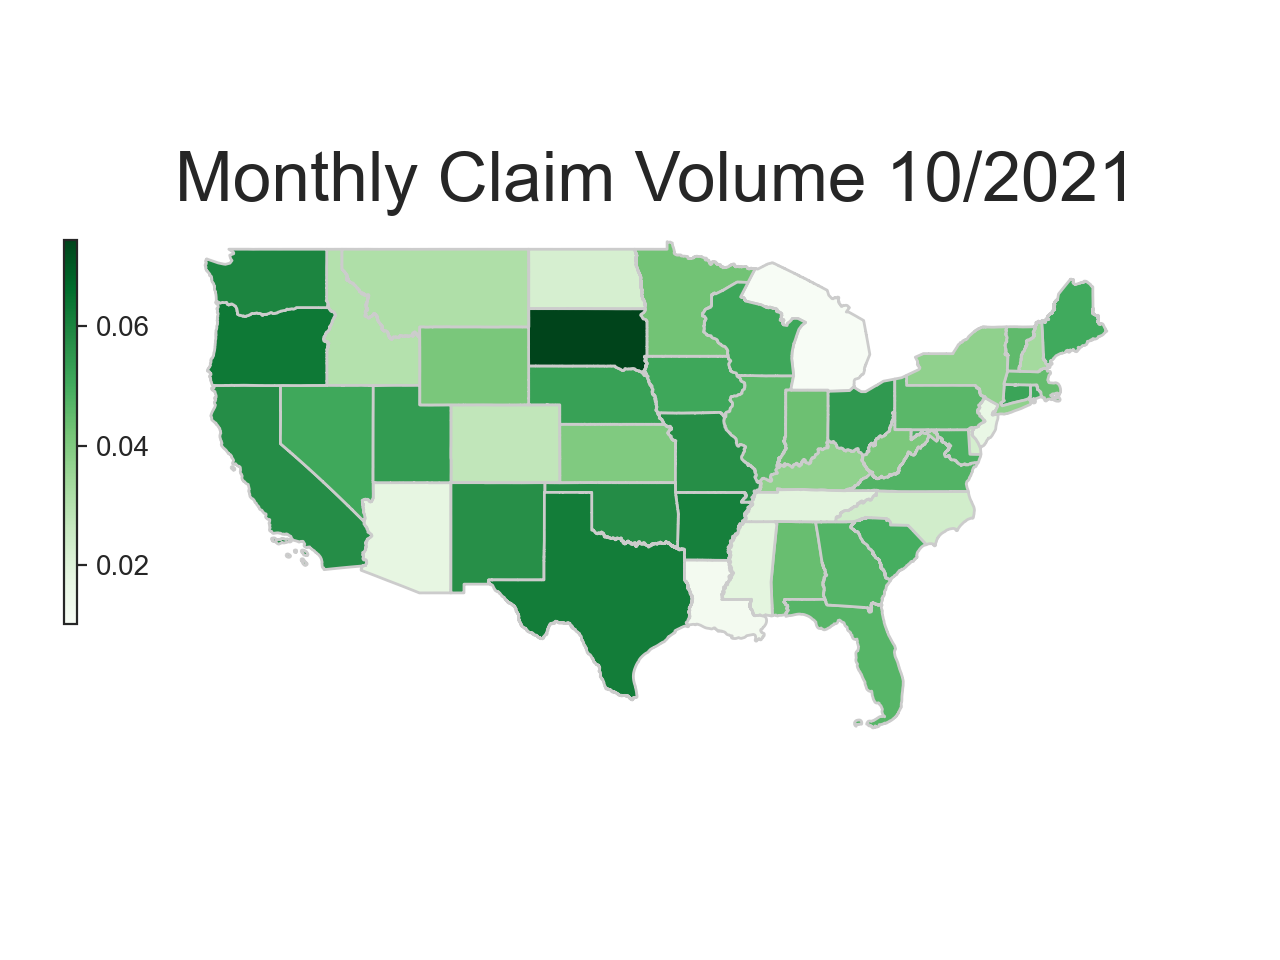

In [305]:
fig = plt.figure()
ax = fig.add_subplot()
ax.axis('off')
col = 'scaled'
colors = 'Greens'
sns.set_style(style = 'white')
cmap = sns.diverging_palette(250, 10, as_cmap=True)
cmap=plt.get_cmap(colors)
vmin = merged_filter[col].min()
vmax = merged_filter[col].max()
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
sm._A = []
cbaxes = fig.add_axes([0.05, 0.35, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)

for month in months:
    ax.cla()
    merged_filter = merged.query("month == @month")
    ax.axis('off')
    merged_filter.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)
    ax.set_title('Monthly Claim Volume ' + str(month) + '/2021', fontdict={'fontsize': '25', 'fontweight': '3'})
    time.sleep(0.1)
    fig.canvas.draw()